# Hyperparameter tuning with cross-validation

### We can always fit data to a model, but how correct is the model?
Julia Wiel, Jonathan Schmidt, Clemens S. Øxnevad and Vitor N. R. Pedreira

## Hyperparameted VS Parameters for Models
**Parameter**

"A model paremeter is an *internal* configurable variable that can be estimated from data"

**Hyperparameter**

"A model hyperparameter is an *external* configuration variable that cannot be estimated from data"

![image](https://victorzhou.com/media/nn-series/network.png)

# Example 1

Problem

We want to find the optimal hyper-parameter $N$
 for the model given as:

$f(x) = \sum_{i=0}^N p_i*x^i$

Where the model consits of the parameters $\textbf{p}$ and the hyperparameter $N$

## Test data


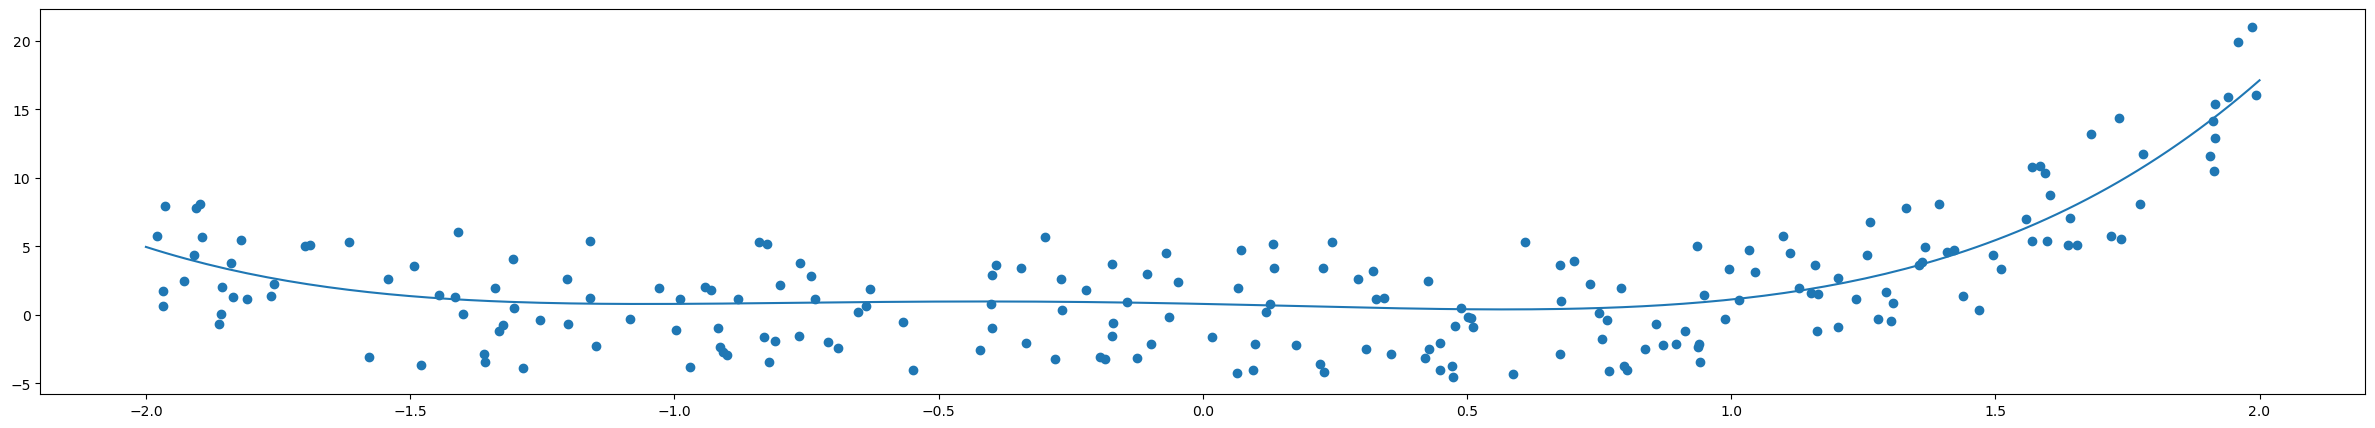

In [1]:
#generate data
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 5]

n = 210
k = 5
a  = 0.8
params =  np.array([1,-1,-a,1.5*a,1])*a


b = 2
x_values = np.random.rand(n)*2*b-b
randomness = np.random.rand(n)*10-5

def f(x,m):
    s = 0
    for i in range(m):
        s += params[i]*x**i
    return s


data = f(x_values,k) + randomness

plt.scatter(x_values, data)
plt.plot(np.linspace(-b,b,n), f(np.linspace(-b,b,n),k))
plt.show()

## Can we spot the correct value of they hyperparamter N?

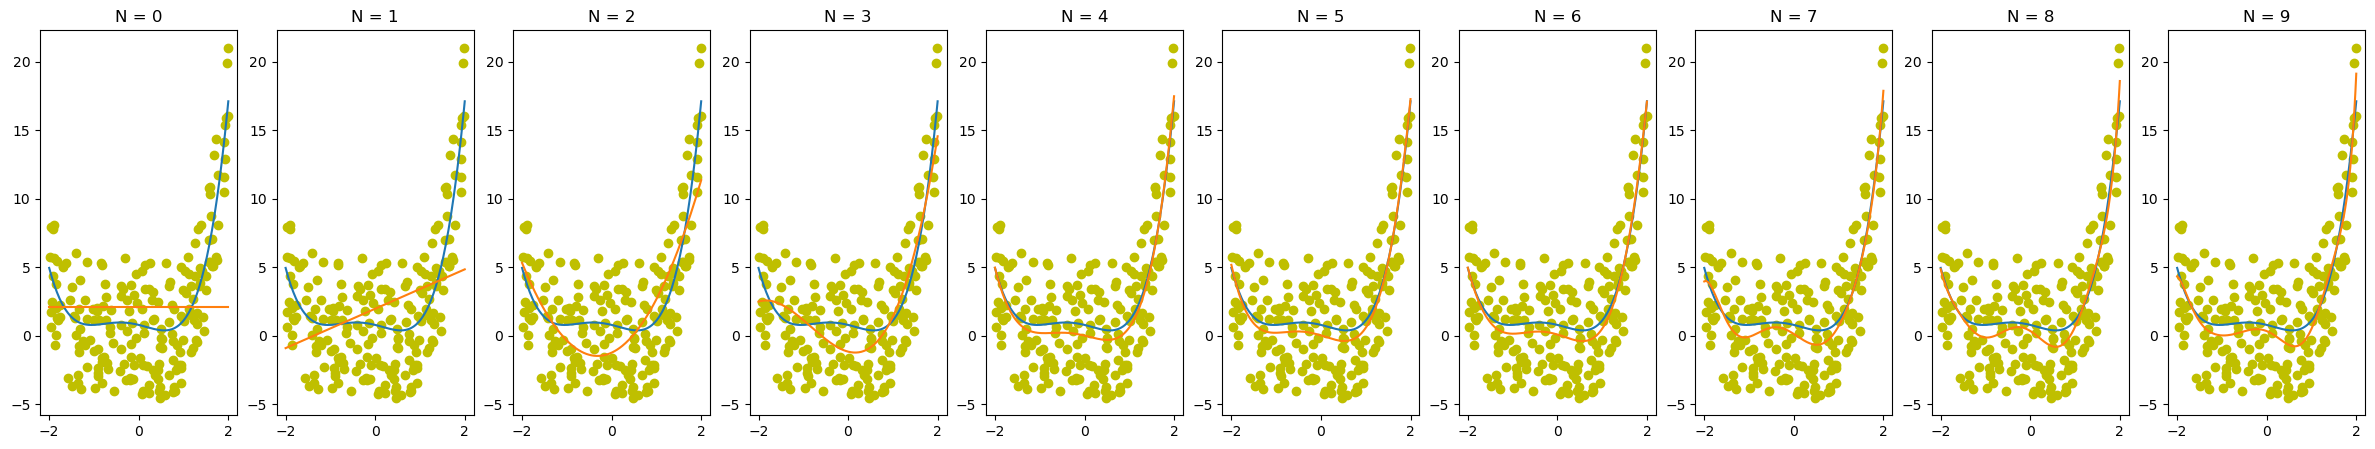

In [2]:
#Plotting different fitted versions of the data
plt.rcParams['figure.figsize'] = [30, 5]
fig, ax = plt.subplots(1,10)
for i in range(10):
    z = np.polyfit(x_values, data, i)
    p = np.poly1d(z)
    res = p(np.linspace(-b,b,n))
    ax[i].scatter(x_values, data,color = 'y')

    ax[i].plot(np.linspace(-b,b,n), f(np.linspace(-b,b,n),k))
    ax[i].plot(np.linspace(-b,b,n),res)
    s = f"N = {i}"
    ax[i].set_title(s)
plt.show()



## We Perform Cross validation!
With 21 sections!

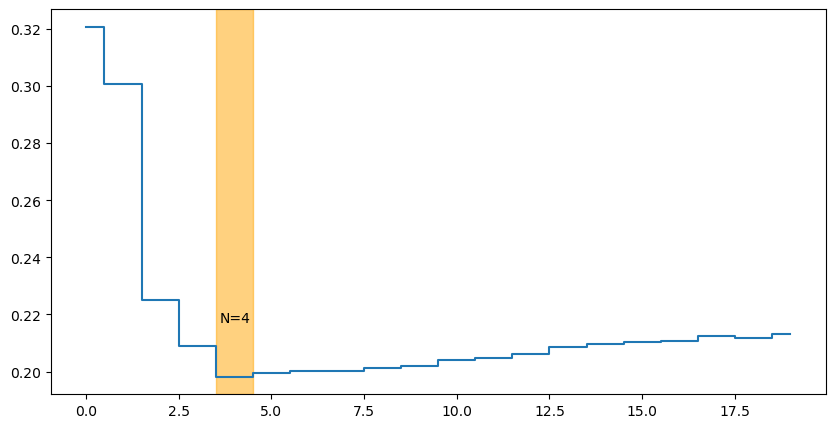

In [3]:
#RMSE of different values of N

plt.rcParams['figure.figsize'] = [10, 5]
def cross_validate(data_x,data_y, sections,plot = False):
    idxs = np.arange(len(data_x))
    np.random.shuffle(idxs)
    l =int(len(data_x)/sections)


    rmse = []
    for p in range(20):
        res=np.array([])

        for i in range(sections):
            validate_idxs = idxs[i*l:(i+1)*l]
            a=idxs[:i*l]
            b = idxs[(i+1)*l:]
            remainder_idxs = np.concatenate((a,b))
            z = np.polyfit(data_x[remainder_idxs], data_y[remainder_idxs], p)
            poly = np.poly1d(z)
            res= np.append(res,poly(data_x[validate_idxs]))


        RMSE = np.sqrt(np.sum((data_y[idxs]-res)**2))/len(data_x)
        rmse.append(RMSE)

    if plot:
        for e in range(len(rmse)):
            pass
            #print(f'Expansion up untill x to the power of {e} provides  an RMSE of {rmse[e]}')

    i = np.argmin(rmse)



    if plot:
        plt.figure()

        plt.axvspan(i-0.5, i+0.5, alpha = 0.5, color = 'orange')
        plt.text(i-0.4, np.average(rmse), f'N={i}', fontsize = 10)
        plt.step(np.arange(len(rmse)), rmse, where = 'mid')
    if not plot:
      return i
cross_validate(x_values, data,21,True)

## Is This a Fluke?
There is some randomness here...

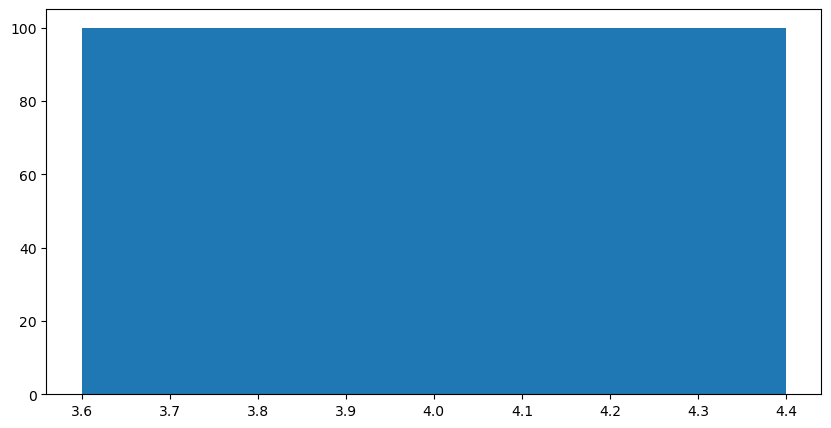

In [4]:
#Simulating over 100 iterations
tot = []
for k in range(100):
    tot.append(cross_validate(x_values, data,21,False))
u,c = np.unique(tot, return_counts = True)
plt.bar(u,c)
plt.show()

## We compare to the RMSE of simple fitting for multiple N

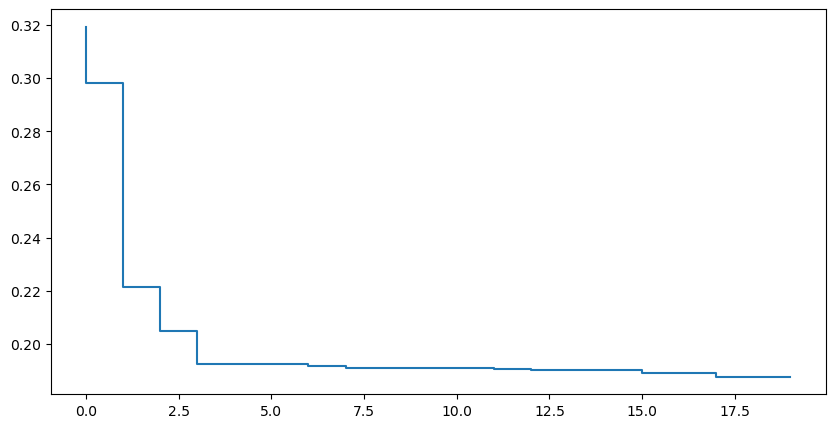

In [5]:
#Compared to pure RMSE for each model
rmse = []
for i in range(20):
    z = np.polyfit(x_values, data, i)
    p = np.poly1d(z)

    res = p(x_values)
    RMSE = np.sqrt(np.sum((data-res)**2))/len(data)
    rmse.append(RMSE)

plt.step(np.arange(20), rmse)
plt.show()





# Methods for finding the optimal hyperparameters

## When we have a single hyperparameter
- Manual tuning
  - Might get lucky
- Validation curve

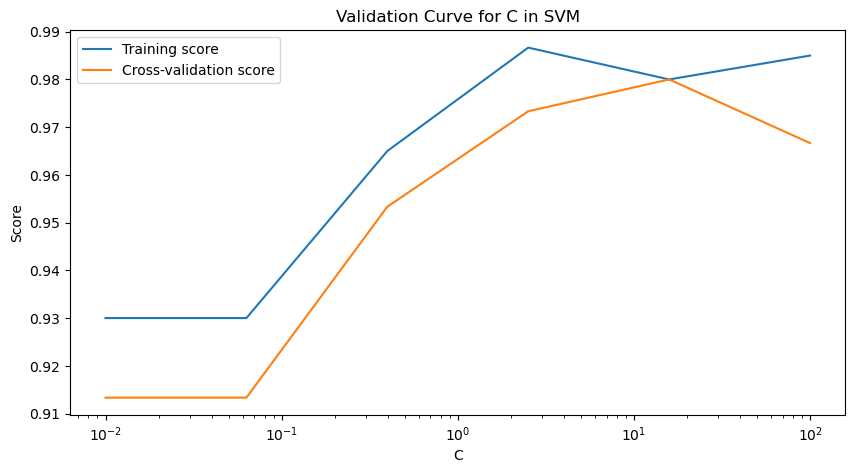

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.datasets import load_iris
from sklearn.svm import SVC

iris = load_iris()
X, y = iris.data, iris.target

param_range = np.logspace(-2, 2, 6)
train_scores, test_scores = validation_curve(SVC(kernel='rbf', gamma=0.1), X, y,
                                             param_name='C', param_range=param_range, cv=5)

plt.semilogx(param_range, train_scores.mean(axis=1), label="Training score")
plt.semilogx(param_range, test_scores.mean(axis=1), label="Cross-validation score")
plt.xlabel('C')
plt.ylabel('Score')
plt.title('Validation Curve for C in SVM')
plt.legend()
plt.show()

## When we have multiple hyperparameters
- Grid search
  - All possible combinations of your defined hyperparameters
- Randomized search
  - Random combinations of the hyper parameters
- Bayesian optimization
  - Utilising past model selection to choose future hyperparameters (iteratively)

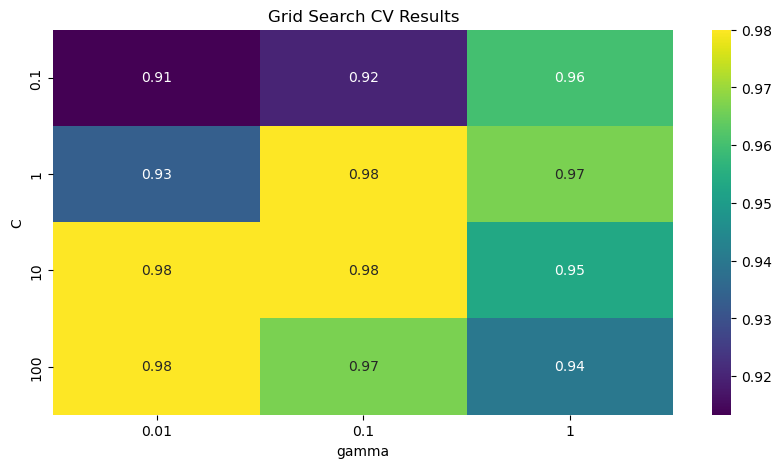

In [53]:
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1], 'kernel': ['rbf']}
grid = GridSearchCV(SVC(), param_grid, cv=5, return_train_score=True)
grid.fit(X, y)

results = grid.cv_results_

scores_matrix = np.array(results['mean_test_score']).reshape(len(param_grid['C']), len(param_grid['gamma']))
sns.heatmap(scores_matrix, annot=True, xticklabels=param_grid['gamma'], yticklabels=param_grid['C'], cmap="viridis")
plt.xlabel('gamma')
plt.ylabel('C')
plt.title('Grid Search CV Results')
plt.show()

# Grid Search Vs Random Search

Grid Search best params: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'} with score: 0.9800000000000001
Random Search best params: {'C': np.float64(8.471801418819979), 'gamma': np.float64(0.06251373574521749), 'kernel': 'rbf'} with score: 0.9866666666666667


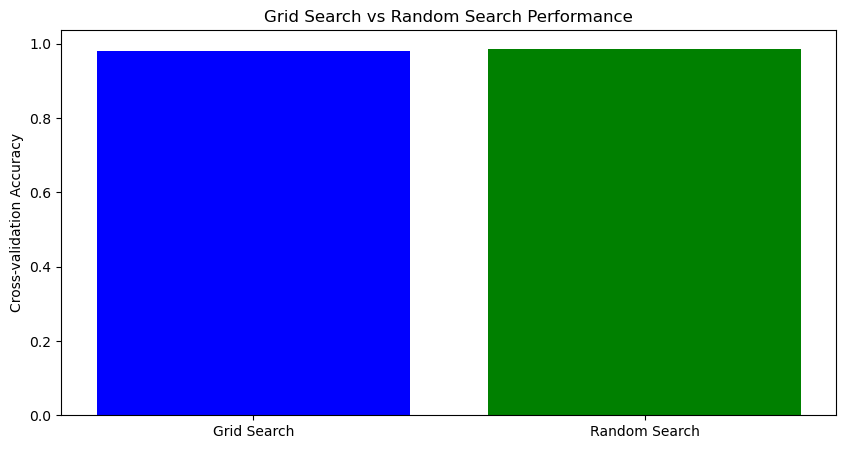

In [54]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

param_dist = {'C': loguniform(0.01, 100), 'gamma': loguniform(0.001, 1), 'kernel': ['rbf']}

random_search = RandomizedSearchCV(SVC(), param_dist, n_iter=10, cv=5, random_state=42, return_train_score=True)
random_search.fit(X, y)

# Compare best results
print("Grid Search best params:", grid.best_params_, "with score:", grid.best_score_)
print("Random Search best params:", random_search.best_params_, "with score:", random_search.best_score_)

# Visualization
methods = ['Grid Search', 'Random Search']
scores = [grid.best_score_, random_search.best_score_]

plt.bar(methods, scores, color=['blue', 'green'])
plt.ylabel('Cross-validation Accuracy')
plt.title('Grid Search vs Random Search Performance')
plt.show()

# Successive Halving Iteration

Grid search and Random search might be slow to compute on large datasets. SHI offers higher efficiency in this case.

**SHI principles:**

At the first iteration, a small amount of resources is used. The resource here is the number of samples that the estimators are trained on. All candidates are evaluated.

At the second iteration, only the best half of the candidates is evaluated. The number of allocated resources is doubled: candidates are evaluated on twice as many samples.

This process is repeated until the last iteration, where only 2 candidates are left. The best candidate is the candidate that has the best score at the last iteration.



## Example: Arctic fox sounds

Comparison Random search and SHI

In [55]:
## Import full fox dataset
import pandas as pd
from tabulate import tabulate

# If the file is in the main working directory
df = pd.read_csv("spectro-analysis_all-labels.csv", sep = ";")

print(tabulate(df.head(10), headers="keys", tablefmt="fancy_grid"))


╒════╤══════════════╤════════════════════════╤═════════╤═══════════════════╤═══════════════════╤═══════════════════╤════════════════════╤════════════════════╤═══════════════════╤════════════════════╤════════════════════╤════════════════════╤═══════════════════╤════════════════════╤══════════════════╤══════════════════╤═══════════════════╤═══════════════════╤═══════════════════╤════════════════════╤════════════════════╤══════════╤══════════╤═══════════╤══════════════════╤════════════╤══════════╤════════════════════╤════════════════════╤══════════════╕
│    │   Unnamed: 0 │ sound.files            │   selec │ duration          │ meanfreq          │ sd                │ freq.median        │ freq.Q25           │ freq.Q75          │ freq.IQR           │ time.median        │ time.Q25           │ time.Q75          │ time.IQR           │ skew             │ kurt             │ sp.ent            │ time.ent          │ entropy           │ sfm                │ meandom            │ mindom   │ maxdom   

In [56]:
## Check number of different fox sounds (fw, ftb...) and sites (H3, H7...)

# 1. Count of each annotation
annotation_counts = df['Annotation'].value_counts()
print("Counts per Annotation:")
print(annotation_counts)

# 2. Extract enclosure ID from 'sound-file' (first 2 characters)
df['Enclosure'] = df['sound.files'].str[:2]

# Count of classes per enclosure
classes_per_enclosure = df.groupby('Enclosure')['Annotation'].nunique()
print("\nNumber of unique classes per Enclosure:")
print(classes_per_enclosure)

annotations_per_enclosure = df.groupby('Enclosure')['Annotation'].count()
print("\nTotal annotations per Enclosure:")
print(annotations_per_enclosure)

Counts per Annotation:
Annotation
fw        902
ftb       616
fc        574
nbird     189
nwind     177
fac       124
nwalk      64
fwp        37
nins       34
fsb        21
nenc       20
fab        15
fwb        14
fgp        12
fg          8
fag         6
nblank      2
fc          1
Name: count, dtype: int64

Number of unique classes per Enclosure:
Enclosure
H3    13
H7    12
H8    11
Name: Annotation, dtype: int64

Total annotations per Enclosure:
Enclosure
H3    1167
H7     874
H8     775
Name: Annotation, dtype: int64


In [57]:
## Keep only subset of the data, compatible with the analysis
df = df[df['Annotation'].isin(['fw', 'ftb', 'fc'])].copy() # Add .copy() to avoid SettingWithCopyWarning

# Drop useless columns
df = df.drop(df.columns[0:2], axis=1)  # drop first two columns by index

# Ensure 'Enclosure' column exists after filtering before dropping
if 'Enclosure' in df.columns:
    df = df.drop(columns=["Enclosure"])  # drop by name
else:
    print("Warning: 'Enclosure' column not found in the DataFrame.")


# Convert feature columns to float (replace commas with periods)
feature_cols = df.drop(columns=["Annotation"]).columns
for col in feature_cols:
    df[col] = df[col].astype(str).str.replace(',', '.')


# y with encoded labels
y = df["Annotation"].values  # labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # 0,1,2

# X with float numbers
X = df.drop(columns=["Annotation"]).values  # feature matrix
X = X.astype(float)

In [58]:
## Run comparison between grid search and successive halving

# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.experimental import enable_halving_search_cv  # noqa: F401
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV
from sklearn.svm import SVC

In [59]:
rng = np.random.RandomState(0)
# X, y = datasets.make_classification(n_samples=1000, random_state=rng)

gammas = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
Cs = [1, 10, 100, 1e3, 1e4, 1e5]
param_grid = {"gamma": gammas, "C": Cs}

clf = SVC(random_state=rng)

tic = time()
gsh = HalvingGridSearchCV(
    estimator=clf, param_grid=param_grid, factor=2, random_state=rng
)

# Print dtypes of X before fitting
print("Data types of X before fitting:", X.dtype)


gsh.fit(X, y)
gsh_time = time() - tic

tic = time()
gs = GridSearchCV(estimator=clf, param_grid=param_grid)
gs.fit(X, y)
gs_time = time() - tic

Data types of X before fitting: float64


# Successive Halving vs Grid Search

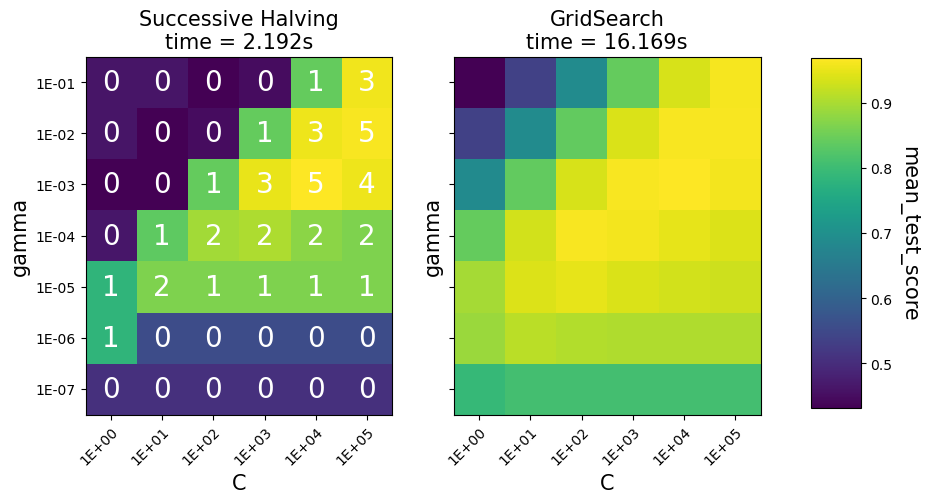

In [60]:
def make_heatmap(ax, gs, is_sh=False, make_cbar=False):
    """Helper to make a heatmap."""
    results = pd.DataFrame(gs.cv_results_)
    results[["param_C", "param_gamma"]] = results[["param_C", "param_gamma"]].astype(
        np.float64
    )
    if is_sh:
        # SH dataframe: get mean_test_score values for the highest iter
        scores_matrix = results.sort_values("iter").pivot_table(
            index="param_gamma",
            columns="param_C",
            values="mean_test_score",
            aggfunc="last",
        )
    else:
        scores_matrix = results.pivot(
            index="param_gamma", columns="param_C", values="mean_test_score"
        )

    im = ax.imshow(scores_matrix)

    ax.set_xticks(np.arange(len(Cs)))
    ax.set_xticklabels(["{:.0E}".format(x) for x in Cs])
    ax.set_xlabel("C", fontsize=15)

    ax.set_yticks(np.arange(len(gammas)))
    ax.set_yticklabels(["{:.0E}".format(x) for x in gammas])
    ax.set_ylabel("gamma", fontsize=15)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    if is_sh:
        iterations = results.pivot_table(
            index="param_gamma", columns="param_C", values="iter", aggfunc="max"
        ).values
        for i in range(len(gammas)):
            for j in range(len(Cs)):
                ax.text(
                    j,
                    i,
                    iterations[i, j],
                    ha="center",
                    va="center",
                    color="w",
                    fontsize=20,
                )

    if make_cbar:
        fig.subplots_adjust(right=0.8)
        cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
        fig.colorbar(im, cax=cbar_ax)
        cbar_ax.set_ylabel("mean_test_score", rotation=-90, va="bottom", fontsize=15)


fig, axes = plt.subplots(ncols=2, sharey=True)
ax1, ax2 = axes

make_heatmap(ax1, gsh, is_sh=True)
make_heatmap(ax2, gs, make_cbar=True)

ax1.set_title("Successive Halving\ntime = {:.3f}s".format(gsh_time), fontsize=15)
ax2.set_title("GridSearch\ntime = {:.3f}s".format(gs_time), fontsize=15)

plt.show()

# Accuracy comparison

In [61]:
# --- Compare GridSearch vs Successive Halving on an external hold-out,
# --- and check if SH dropped good configs too early.

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import pandas as pd
import numpy as np

# 1) Make a proper external hold-out set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

def fit_eval(params, name):
    """Fit SVC with given params on train, evaluate on test."""
    m = SVC(**params, random_state=0)
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return {"who": name, "params": params, "test_acc": acc, "model": m}

results_rows = []

# 2) Winners from each search, refit on train, evaluate on hold-out
results_rows.append(fit_eval(gs.best_params_, "GridSearch BEST"))
results_rows.append(fit_eval(gsh.best_params_, "SuccessiveHalving BEST"))

# 3) Identify configs that SH discarded early, but which looked good to GridSearch
df_gs  = pd.DataFrame(gs.cv_results_)
df_sh  = pd.DataFrame(gsh.cv_results_)

# Normalize param dtypes for safe merges
for col in ["param_C", "param_gamma"]:
    df_gs[col] = df_gs[col].astype(float)
    df_sh[col] = df_sh[col].astype(float)

# For SH: get the max iteration reached per (C, gamma)
sh_iters = (
    df_sh.groupby(["param_C", "param_gamma"])["iter"]
    .max()
    .reset_index(name="max_iter")
)

first_iter = sh_iters["max_iter"].min()  # typically the earliest iteration index
discarded_early = sh_iters[sh_iters["max_iter"] == first_iter][["param_C", "param_gamma"]]

# Join with GridSearch scores to see which "early discards" looked promising under full CV
gs_scores = df_gs[["param_C", "param_gamma", "mean_test_score"]]
rescued = (
    discarded_early.merge(gs_scores, on=["param_C", "param_gamma"], how="left")
    .dropna(subset=["mean_test_score"])
    .sort_values("mean_test_score", ascending=False)
)

# 4) Evaluate the top-N of those early discards on the hold-out (fully trained)
TOP_N = 5
for _, row in rescued.head(TOP_N).iterrows():
    params = {"C": float(row["param_C"]), "gamma": float(row["param_gamma"]), "kernel": "rbf"}
    results_rows.append(fit_eval(params, f"SH early-discard (rescued) C={params['C']}, γ={params['gamma']}"))

# 5) Summarize
summary = pd.DataFrame(
    [{"who": r["who"], "test_acc": r["test_acc"], "params": r["params"]} for r in results_rows]
).sort_values("test_acc", ascending=False)

print("=== Hold-out test accuracy comparison ===")
print(summary.to_string(index=False))

best = summary.iloc[0]
print("\nBest on hold-out:", best["who"], "with", best["params"])

# Optional: quick verdict hints
gs_cv = gs.best_score_
sh_cv = gsh.best_score_
print(f"\nCV scores: GridSearch={gs_cv:.4f} | SH={sh_cv:.4f}")
print("If a method's CV score >> its hold-out score here, it likely overfit the CV.")
print("If any rescued early-discard beats SH BEST on hold-out, SH probably dropped it too early.")


=== Hold-out test accuracy comparison ===
                                          who  test_acc                                          params
                              GridSearch BEST  0.963671                  {'C': 10000.0, 'gamma': 1e-05}
                       SuccessiveHalving BEST  0.963671                  {'C': 10000.0, 'gamma': 1e-05}
   SH early-discard (rescued) C=100.0, γ=0.01  0.948375    {'C': 100.0, 'gamma': 0.01, 'kernel': 'rbf'}
    SH early-discard (rescued) C=10.0, γ=0.01  0.944551     {'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}
 SH early-discard (rescued) C=10000.0, γ=0.01  0.942639  {'C': 10000.0, 'gamma': 0.01, 'kernel': 'rbf'}
  SH early-discard (rescued) C=1000.0, γ=0.01  0.942639   {'C': 1000.0, 'gamma': 0.01, 'kernel': 'rbf'}
SH early-discard (rescued) C=100000.0, γ=0.01  0.942639 {'C': 100000.0, 'gamma': 0.01, 'kernel': 'rbf'}

Best on hold-out: GridSearch BEST with {'C': 10000.0, 'gamma': 1e-05}

CV scores: GridSearch=0.9685 | SH=0.9687
If a method's

# Potential of Overfitting

In [62]:
import pandas as pd
import numpy as np

# Helper: fetch 'summary' table from previous cell or rebuild from 'results_rows'
if 'summary' not in globals():
    if 'results_rows' in globals():
        summary = pd.DataFrame(
            [{"who": r["who"], "test_acc": r["test_acc"], "params": r["params"]} for r in results_rows]
        ).sort_values("test_acc", ascending=False)
    else:
        raise RuntimeError("I couldn't find 'summary' or 'results_rows'. Please run the previous comparison cell first.")

# ---- 1) Overfitting check: CV vs Hold-out for GridSearch and SH ----
def _get_holdout(who_label: str) -> float:
    row = summary.loc[summary['who'] == who_label]
    return float(row['test_acc'].iloc[0]) if not row.empty else np.nan

overfit_threshold = 0.02  # you can change this if you want a stricter/looser flag

overfit_rows = []
# GridSearch
overfit_rows.append({
    "method": "GridSearch",
    "cv_score": float(gs.best_score_) if 'gs' in globals() else np.nan,
    "holdout_acc": _get_holdout("GridSearch BEST"),
})
# Successive Halving
overfit_rows.append({
    "method": "SuccessiveHalving",
    "cv_score": float(gsh.best_score_) if 'gsh' in globals() else np.nan,
    "holdout_acc": _get_holdout("SuccessiveHalving BEST"),
})

overfit_df = pd.DataFrame(overfit_rows)
overfit_df["gap (cv - holdout)"] = overfit_df["cv_score"] - overfit_df["holdout_acc"]
overfit_df["overfit? (gap > {:.2f})".format(overfit_threshold)] = overfit_df["gap (cv - holdout)"] > overfit_threshold
overfit_df = overfit_df[["method", "cv_score", "holdout_acc", "gap (cv - holdout)", "overfit? (gap > {:.2f})".format(overfit_threshold)]]

try:
    from caas_jupyter_tools import display_dataframe_to_user
    display_dataframe_to_user("Overfitting check: CV vs Hold-out", overfit_df)
except Exception:
    pass

print("Overfitting check:")
display(overfit_df)

# ---- 2) Early-drop check: Did SH discard better configs? ----
sh_best = summary.loc[summary['who'] == "SuccessiveHalving BEST"]
sh_best_acc = float(sh_best['test_acc'].iloc[0]) if not sh_best.empty else np.nan

rescued_mask = summary['who'].str.startswith("SH early-discard")
rescued_table = summary.loc[rescued_mask, ['who', 'test_acc', 'params']].copy()
rescued_table["Δ vs SH best"] = rescued_table["test_acc"] - sh_best_acc
rescued_table["beats SH best?"] = rescued_table["Δ vs SH best"] > 0
rescued_table = rescued_table.sort_values(["beats SH best?", "Δ vs SH best"], ascending=[False, False]).reset_index(drop=True)

try:
    display_dataframe_to_user("Did SH drop good configs early? (rescued vs SH best)", rescued_table)
except Exception:
    pass

print("\nEarly-drop analysis (rescued configs vs SH best):")
display(rescued_table.head(15))


Overfitting check:


,method,cv_score,holdout_acc,gap (cv - holdout),overfit? (gap > 0.02)
0,GridSearch,0.968463,0.963671,0.004792,False
1,SuccessiveHalving,0.968718,0.963671,0.005046,False



Early-drop analysis (rescued configs vs SH best):


,who,test_acc,params,Δ vs SH best,beats SH best?
0,"SH early-discard (rescued) C=100.0, γ=0.01",0.948375,"{'C': 100.0, 'gamma': 0.01, 'kernel': 'rbf'}",-0.015296,False
1,"SH early-discard (rescued) C=10.0, γ=0.01",0.944551,"{'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'}",-0.019120,False
2,"SH early-discard (rescued) C=10000.0, γ=0.01",0.942639,"{'C': 10000.0, 'gamma': 0.01, 'kernel': 'rbf'}",-0.021033,False
3,"SH early-discard (rescued) C=1000.0, γ=0.01",0.942639,"{'C': 1000.0, 'gamma': 0.01, 'kernel': 'rbf'}",-0.021033,False
4,"SH early-discard (rescued) C=100000.0, γ=0.01",0.942639,"{'C': 100000.0, 'gamma': 0.01, 'kernel': 'rbf'}",-0.021033,False


# Results of Successive Halving

Best params from Successive Halving: {'C': 10000.0, 'gamma': 1e-05}
Hold-out accuracy (SH best): 0.9637

Classification report (SH best):
              precision    recall  f1-score   support

          fc       1.00      0.99      1.00       144
         ftb       0.93      0.95      0.94       154
          fw       0.96      0.95      0.96       225

    accuracy                           0.96       523
   macro avg       0.96      0.97      0.97       523
weighted avg       0.96      0.96      0.96       523



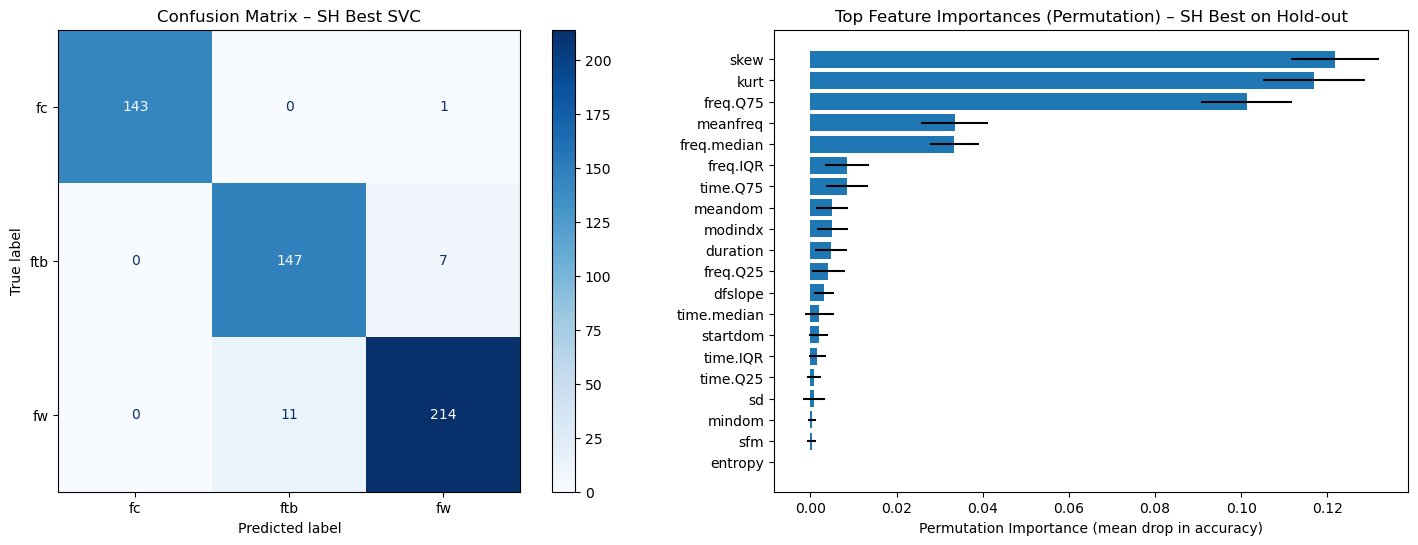

In [63]:
# --- Apply the best Successive Halving (SH) model to classify the data and plot results ---

import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

# --- 1) Get best hyperparameters from SH and train a final model on the train split ---
best_sh_params = gsh.best_params_
print("Best params from Successive Halving:", best_sh_params)

clf_sh = SVC(**best_sh_params, probability=True, random_state=0)
clf_sh.fit(X_train, y_train)

# --- 2) Predict on the hold-out set and report metrics ---
y_pred = clf_sh.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Hold-out accuracy (SH best): {acc:.4f}")
print("\nClassification report (SH best):")
print(classification_report(y_test, y_pred))

# --- 3) Confusion matrix plot ---
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
fig, ax = plt.subplots(1,2, figsize=(18, 6))
disp.plot(ax=ax[0], cmap="Blues", colorbar=True)
ax[0].set_title("Confusion Matrix – SH Best SVC")
#ax[0].tight_layout()
#plt.show()


# --- 4) Feature relevance (Permutation Importance) on hold-out set ---
from sklearn.inspection import permutation_importance

# Try to get feature names from the original dataframe (if available)
if "df" in globals() and "Annotation" in df.columns:
    feature_names = df.drop(columns=["Annotation"]).columns.tolist()
else:
    feature_names = [f"f{i}" for i in range(X.shape[1])]

perm = permutation_importance(
    clf_sh, X_test, y_test,
    scoring="accuracy",
    n_repeats=20,
    random_state=0,
    n_jobs=-1
)

importances = perm.importances_mean
stds = perm.importances_std
idx = np.argsort(importances)[::-1]  # sort descending

top_k = min(20, len(importances))  # show top 20
#ax[1].figure(figsize=(8, 7))
y_pos = np.arange(top_k)
ax[1].barh(y_pos, importances[idx][:top_k], xerr=stds[idx][:top_k])
ax[1].invert_yaxis()
ax[1].set_yticks(y_pos, [feature_names[i] for i in idx[:top_k]])
ax[1].set_xlabel("Permutation Importance (mean drop in accuracy)")
ax[1].set_title("Top Feature Importances (Permutation) – SH Best on Hold-out")
#plt.tight_layout()
plt.show()



